In [74]:
#we import the libraries 
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.image as mpimg

In [75]:
def stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,y,boundary):
    '''Performs Jacobi relaxation for the cavity flow
    
    Parameters:
    ----------
    w : 2D array of floats
        Initial guess
    psi: 2D array of floats
        Initial guess
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l1_target: float
        Target difference between two consecutive iterates
    boundary: integer
        determine the BCS function tu use
    Returns:
    -------
    psi: 2D array of float
        Distribution after relaxation
    iteration: number of iteration
    ''' 
    iteration=0
    stop1=1
    stop2=1
    psin = numpy.empty_like(psi)
    wn= numpy.empty_like(w)
    wk= numpy.empty_like(w)
    wk=w.copy()
    
    while(stop1>l1_target or stop2>l1_target):
        
        psin=psi.copy()
        wn=wk.copy()
        wk[1:-1,1:-1]=.25*(wn[2:,1:-1]+wn[:-2,1:-1]+wn[1:-1,:-2]+wn[1:-1,2:])
        
        psi[1:-1:,1:-1]=.25*((dx**2)*wn[1:-1,1:-1]+psin[2:,1:-1] \
                             +psin[:-2,1:-1]+psi[1:-1,:-2]+psin[1:-1,2:]) 
        
        #BCs function to use
        if boundary==1:
            psi,wk = BCs_obstacle1(wk,psi,y,xi,yi,r,h,u)
        if boundary==2:    
            psi,wk = BCs_obstacle2(wk,psi,y,xi,yi,r,h,u)  
        if boundary==3:   
            psi,wk = BCs_obstacle3(wk,psi,y,xi,yi,r,h,u)
        
        stop1=L1norm(psi,psin)
        stop2=L1norm(wk,wn)
        iteration+=1
        
        if iteration>50000:
            break
        
    return wk,psi, iteration

In [76]:
def BCs_obstacle1(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    return psi,w


In [77]:
def L1norm(new, old):
    '''compute the norm between psi(k+1) and psi(k)
    
    Parameters:
    ----------
    new : 2D array of floats
        psi(k+1)
    old: 2D array of floats
        psi(k)
        
    Returns:
    -------
    norm: float
        norm between psi(k) and psi(k+1)
    ''' 
    norm = numpy.sum(numpy.abs(new-old))
    return norm


In [78]:
# resolution 
nx=41
ny=41
    
# cavity of length l and height h
l=1
h=1

# speed of the flow u
u=1

#dimension of the central square
r=int((nx-1)/10)
#position of the center of the square
xi=int((nx-1)/2)
yi=int((ny-1)/2)

#grid
x=numpy.linspace(0,l,nx)
y=numpy.linspace(0,h,ny)
#grid mesh
dx=l/(nx-1)
dy=h/(ny-1)

#norm target
l1_target = 1e-6

#potential flow
w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))

In [79]:
#values of psi=u*y on the cavity's boundaries
psi[:,0]=u*y[:]
psi[:,-1]=u*y[:]
psi[-1,:]=u*y[-1]
psi[0,:]=u*y[0]

In [80]:
def BCs_obstacle2(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-psi[yi-r-2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-psi[yi-r:yi+r+1,xi-r-2])
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-psi[yi+r+2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

number of iterations = 1934


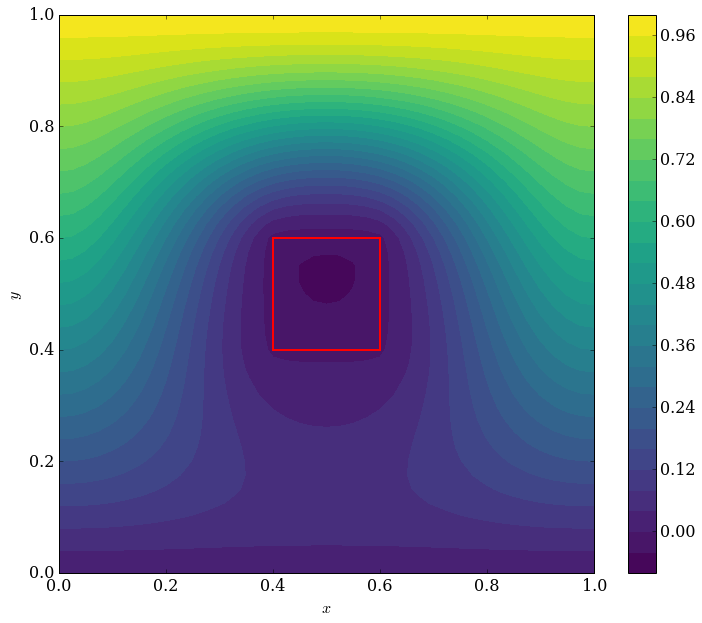

In [81]:
#we choose the second BCs function
boundary=2

#compute psi
w2,psi2,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,y,boundary)
print("number of iterations =",iteration)
 
j=numpy.linspace(x[xi-r],x[xi+r],100)
p=numpy.linspace(y[yi-r],y[yi+r],100)
k=numpy.zeros(100)
l=numpy.zeros(100)
m=numpy.zeros(100)
n=numpy.zeros(100)
k[:]=x[xi+r]
l[:]=x[xi-r]
m[:]=y[yi+r]
n[:]=y[yi-r]
pyplot.figure(figsize=(12,10))
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.contourf(x,y,psi2,26,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [82]:
def speed(psi,nx,ny,dx,dy):
    '''compute the speed from the potential
    
    Parameters:
    ----------
    psi : 2D array of floats
        potential
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    ux: 2D array of float
        speed in the x direction
    vy:2D array of float
        speed in the y direction
    ''' 
    ux=numpy.zeros((nx,ny))
    vy=numpy.zeros((nx,ny))
    
    ux[:,0]=u
    ux[:,-1]=u
    ux[0,:]=u
    ux[-1,:]=u
    ux[1:-1,1:-1]=(1/(2*dy))*(psi[2:,1:-1]-psi[0:-2,1:-1])
    
    vy[:,0]=0
    vy[:,-1]=0
    vy[0,:]=0
    vy[-1,:]=0
    vy[1:-1,1:-1]=-(1/(2*dx))*(psi[1:-1,2:]-psi[1:-1,0:-2])
    
    return ux,vy

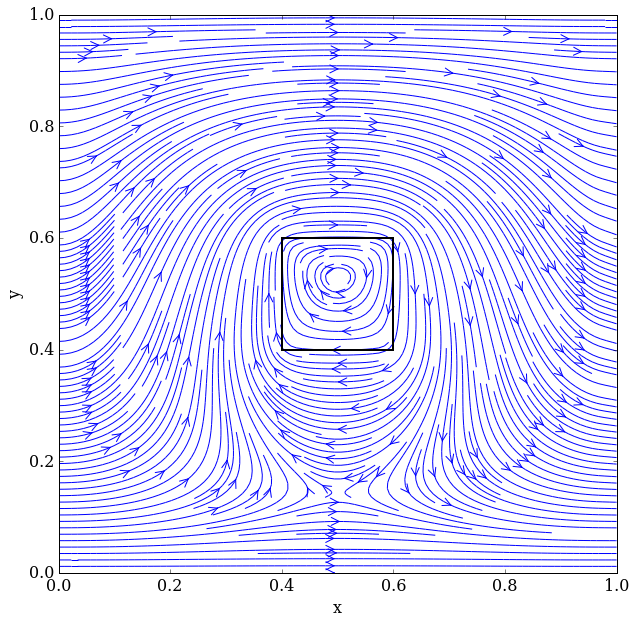

In [83]:
#plot of the flow speed
ux2, vy2=speed(psi2,nx,ny,dx,dy)
X, Y =numpy.meshgrid(x,y)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.streamplot(X, Y, ux2, vy2, density=3, linewidth=1, arrowsize=2, arrowstyle='->')

In [84]:
def BCs_obstacle3(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi-r-2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi-r-2])
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi+r+2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

In [85]:
#we choose the third BCs function
boundary=3

#compute psi
w3,psi3,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,y,boundary)
print("number of iterations =",iteration)
print(w2[15,15])
print(w3[15,15])

number of iterations = 1889
-13.5211988629
13.458622091


In [86]:
dw_x3, dw_y3 = grad(w3,dx,dy,nx,ny,xi,yi,r) 
print(dw_x3[15,15])
contw3=cont(dw_x3,dw_y3,dx,dy,yi,xi,r)
print("integral with the first choice of constant=",contw3)

169.086716648
integral with the first choice of constant= 7.99096815826


In [87]:
dw_x2, dw_y2 = grad(w2,dx,dy,nx,ny,xi,yi,r) 
print(dw_x2[15,15])
contw2=cont(dw_x2,dw_y2,dx,dy,yi,xi,r)
print("integral with the second choice of constant=",contw2)

-98.7066494901
integral with the second choice of constant= 7.99096815656


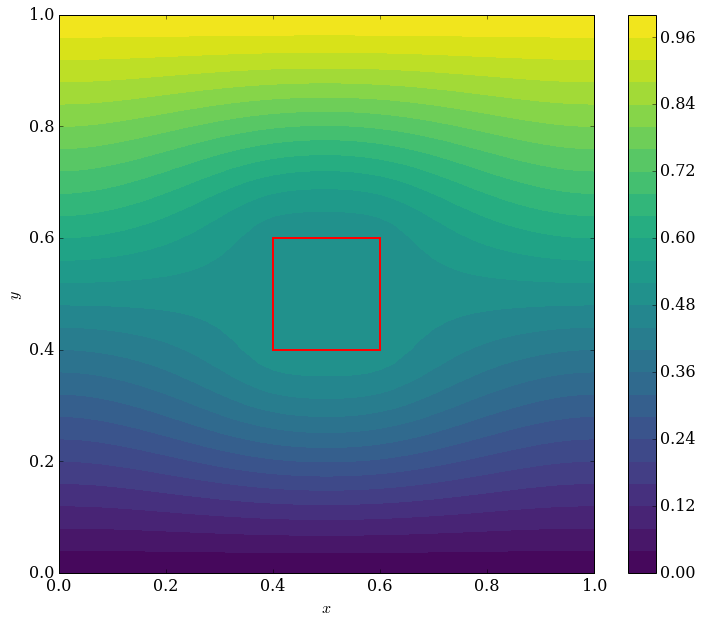

In [88]:
pyplot.figure(figsize=(12,10))
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.contourf(x,y,psi3,26,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

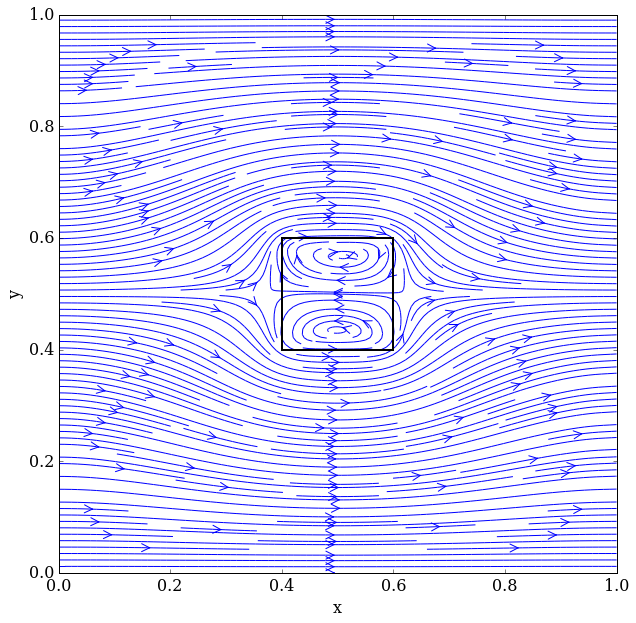

In [89]:
ux3, vy3=speed(psi3,nx,ny,dx,dy)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.streamplot(X, Y, ux3, vy3, density=3, linewidth=1, arrowsize=2, arrowstyle='->')

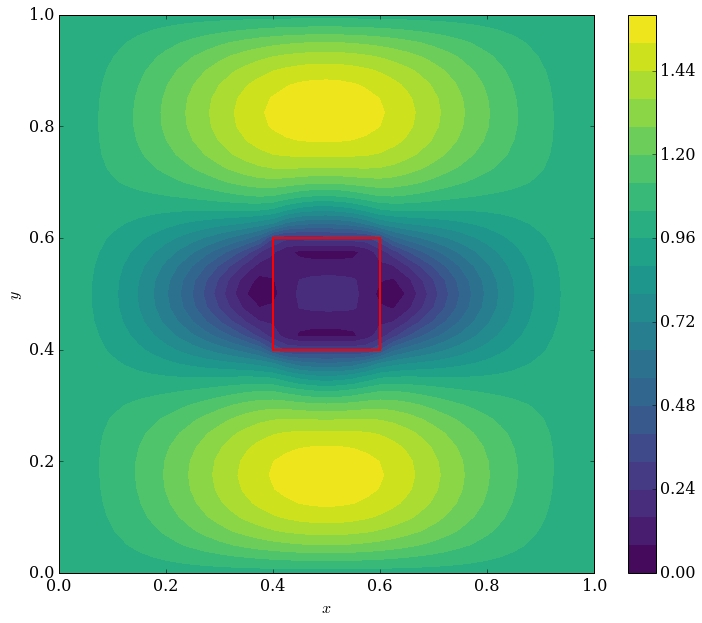

In [90]:
u2=numpy.zeros((nx,ny))
u2[:,:]=numpy.sqrt(((ux3[:,:])**2+(vy3[:,:])**2))
pyplot.figure(figsize=(12,10))
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.contourf(x,y,u2,20,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [91]:
def cont(fx,fy,dx,dy,yi,xi,r):
    
    fu=numpy.zeros((2*r+1))
    fd=numpy.zeros((2*r+1))
    fr=numpy.zeros((2*r+1))
    fl=numpy.zeros((2*r+1))
    fu[:]=fx[yi+r+1,xi-r:xi+r+1]
    fd[:]=fx[yi-r-1,xi-r:xi+r+1]
    fr[:]=fy[yi-r:yi+r+1,xi+r+1]
    fl[:]=fy[yi-r:yi+r+1,xi-r+1]
    cont=numpy.sum(-dx*(-fu+fd)+dy*(fr-fl))
    
    return cont

In [97]:
def grad(w,dx,dy,nx,ny,xi,yi,r):
    dw_x=numpy.zeros((nx,ny))
    dw_y=numpy.zeros((nx,ny))
    dw_x[1:-1,1:-1]=(w[1:-1,2:]-w[1:-1,:-2])/(2*dx)
    dw_y[1:-1,1:-1]=(w[2:,1:-1]-w[:-2,1:-1])/(2*dy)
    return dw_x, dw_y

print("w3=",w3[15,15])
dw_x3, dw_y3 = grad(w3,dx,dy,nx,ny,xi,yi,r) 
contw3=cont(dw_x3,dw_y3,dx,dy,yi,xi,r)
print("grad3=",dw_x3[12,12], dw_y3[12,12])
print(contw3)

print("w2=",w2[15,15])
dw_x2, dw_y2 = grad(w2,dx,dy,nx,ny,xi,yi,r) 
contw2=cont(dw_x2,dw_y2,dx,dy,yi,xi,r)
print("grad2=",dw_x2[12,12], dw_y2[12,12])
print(contw2)

w3= 13.458622091
grad3= 38.4150694626 25.0976338741
7.99096815826
w2= -13.5211988629
grad2= -32.3572224712 -45.6746580604
7.99096815656


In [17]:
def Force (ux,uy,nx,ny,dx,dy):
    '''compute the force from the speed
    Parameters:
    ----------
    ux : 2D array of floats
        speed in the x-direction
    uy : 2D array of floats
        speed in the y-direction    
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    Returns:
    -------
    Fx: 2D array of float
        force in the x direction
    Fy:2D array of float
        force in the y direction
    '''
    Fx=numpy.zeros((nx,ny))
    Fy=numpy.zeros((nx,ny))
    Fx[1:-1,1:-1]=-(1/(dx**2))*(ux[1:-1,2:]-2*ux[1:-1,1:-1]+ux[1:-1,:-2])-(1/(dy**2))*(ux[2:,1:-1]-2*ux[1:-1,1:-1]+ux[:-2,1:-1])
    Fy[1:-1,1:-1]=-(1/(dx**2))*(uy[1:-1,2:]-2*uy[1:-1,1:-1]+uy[1:-1,:-2])-(1/(dy**2))*(uy[2:,1:-1]-2*uy[1:-1,1:-1]+uy[:-2,1:-1])
    return Fx,Fy

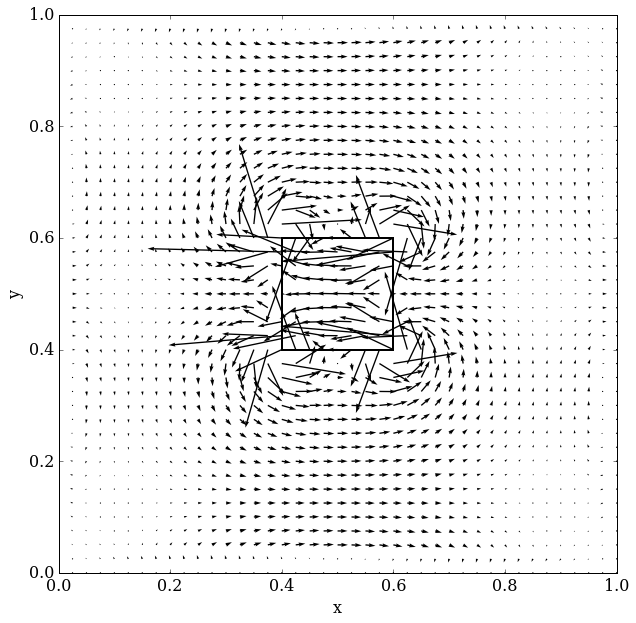

In [18]:
Fx3,Fy3 = Force (ux3,vy3,nx,ny,dx,dy)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.quiver(x,y,Fx3,Fy3)

In [19]:
def cont(fx,fy,dx,dy,yi,xi,r):
    
    fu=numpy.zeros((2*r+1))
    fd=numpy.zeros((2*r+1))
    fr=numpy.zeros((2*r+1))
    fl=numpy.zeros((2*r+1))
    fu[:]=fx[yi+r+1,xi-r:xi+r+1]
    fd[:]=fx[yi-r-1,xi-r:xi+r+1]
    fr[:]=fy[yi-r:yi+r+1,xi+r+1]
    fl[:]=fy[yi-r:yi+r+1,xi-r+1]
    cont=numpy.sum(dx*(-fu+fd)+dy*(fr-fl))
    
    return cont

contF3=cont(Fx3,Fy3,dx,dy,yi,xi,r)

print(contF3)

Fx2,Fy2 = Force (ux2,vy2,nx,ny,dx,dy)
contF2=cont(Fx2,Fy2,dx,dy,yi,xi,r)

print(contF2)


1.72951385536
-47.4191362709


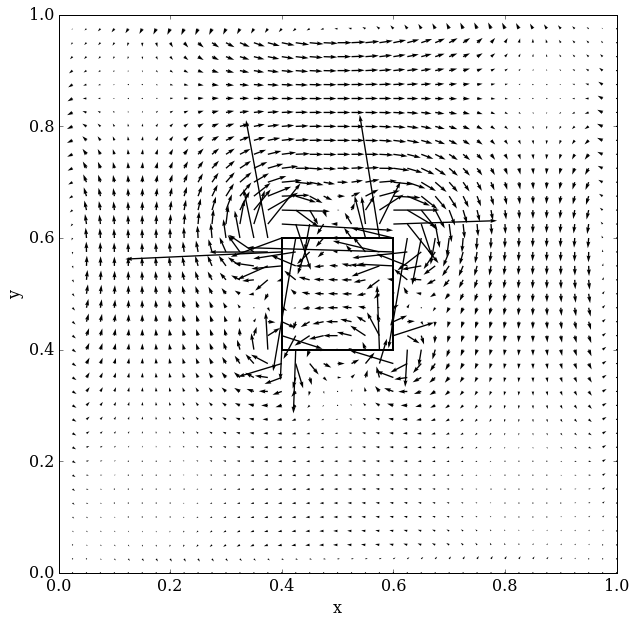

In [21]:
Fx2,Fy2 = Force (ux2,vy2,nx,ny,dx,dy)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.quiver(x,y,Fx2,Fy2)